In [250]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import datetime
import seaborn as sbs
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import  GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

In [251]:
df=pd.read_csv('589Data.csv')

In [252]:
df['NoShowHistory'].value_counts()

0.0     67483
1.0     28508
2.0      8984
3.0      2923
4.0      1215
5.0       552
6.0       337
7.0       161
8.0       114
11.0       65
10.0       50
9.0        31
12.0       23
15.0       20
18.0       18
16.0       16
14.0       14
13.0       13
Name: NoShowHistory, dtype: int64

Ques 1. Check for imbalance in data

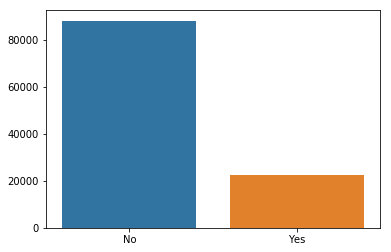

In [253]:
groups = df.groupby(['No-show'])
gps = groups.size()
ax = sbs.barplot(x=gps.index.tolist(), y=gps.values)
plt.show()

In [254]:
gps = groups.size()
total= gps['No']+gps['Yes']
gps['Prop_no_show']= (gps['No']/total*100)
gps['Prop_show']=(gps['Yes']/total*100)
gps

No-show
No              88208.000000
Yes             22319.000000
Prop_no_show       79.806744
Prop_show          20.193256
dtype: float64

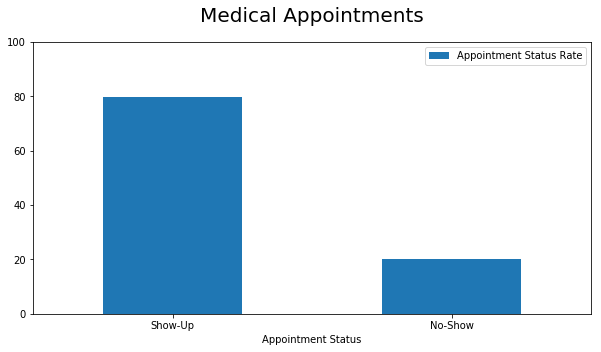

In [255]:
#check number of not showing up patinets to an appointment on scale of 100
#group by no-show column
no_show_percentage = pd.DataFrame(df.groupby(["No-show"])["PatientId"].count())
#calculate percentage of show up and no show and store it in column No-Show
no_show_percentage["No-show"] = no_show_percentage["PatientId"] / sum(no_show_percentage["PatientId"]) * 100
no_show_percentage.drop(columns="PatientId", inplace=True)
#plot the dataframe 
no_show_percentage.plot.bar(figsize=(10,5))
plt.ylim(top=100)
plt.title("Medical Appointments",{'fontsize': 20},pad=20)
plt.xlabel("Appointment Status")
plt.xticks(np.arange(2), ('Show-Up', 'No-Show'), rotation=0)
plt.legend(["Appointment Status Rate"])

In [256]:
from sklearn.utils import resample

In [257]:
# Transform into binary classification
df['No-show'] = [1 if b=='Yes' else 0 for b in df['No-show']] 
df['No-show'].value_counts()


0    88208
1    22319
Name: No-show, dtype: int64

Balancing the data by using Oversampling method

In [258]:
# Separate majority and minority classes
df_majority = df[df['No-show']==0]
df_minority = df[df['No-show']==1]
 
# Oversample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=88208,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with Oversampled minority class
df_oversampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_oversampled['No-show'].value_counts()

1    88208
0    88208
Name: No-show, dtype: int64

Ques 3. Dropping unnecessary variables

In [259]:
#dropping patient_id and appointment_id
df_oversampled.drop(columns=['PatientId', 'AppointmentID'], inplace=True)
df_oversampled.columns

Index(['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood',
       'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received', 'No-show', 'Age_cat', 'WeekdayAppointment',
       'NoShowHistory', 'AwaitingTime'],
      dtype='object')

Ques2. Getting dummies of categorical variables

In [ ]:
def one_hot_encode(data):
    return pd.get_dummies(data)



Ques 4. Splitting Data into training and test set

In [284]:
from sklearn.model_selection import train_test_split
encoded_data = one_hot_encode(df_oversampled)

X = encoded_data.drop(columns='No-show')
y = encoded_data['No-show']
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=.5, random_state=7)

In [285]:
X_train.shape, y_train.shape

((88208, 238), (88208,))

Ques 5. Applying Logistic Regression and generating report

In [288]:
# logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
print('Logistic Regression')
print('test accuracy',acc_log)
from sklearn.metrics import classification_report
print(classification_report(y_pred,y_test))



Logistic Regression
test accuracy 89.35
             precision    recall  f1-score   support

          0       0.84      0.95      0.89     38901
          1       0.95      0.86      0.90     49307

avg / total       0.90      0.90      0.90     88208



Using 5-fold crossvalidation on training set

In [290]:
logreg = LogisticRegression()
print('Accuracy at each fold',cross_val_score(logreg, X_train,y_train, scoring='accuracy', cv = 5))
print('AUC at each fold',cross_val_score(logreg, X_train,y_train, scoring='roc_auc', cv = 5))
print('Precision at each fold',cross_val_score(logreg, X_train,y_train, scoring='precision', cv = 5))
print('Recall at each fold',cross_val_score(logreg, X_train,y_train, scoring='recall', cv = 5))
print('F-1 score at each fold',cross_val_score(logreg, X_train,y_train, scoring='f1', cv = 5))

Accuracy at each fold [0.89411631 0.89332275 0.89224578 0.89156558 0.894161  ]
AUC at each fold [0.91016612 0.91094532 0.90970922 0.90815977 0.91169609]
Precision at each fold [0.85158399 0.84987303 0.84823601 0.84755727 0.85115475]
Recall at each fold [0.95314103 0.95393912 0.95393912 0.95336906 0.95393387]
F-1 score at each fold [0.89950506 0.89890417 0.89798766 0.89735472 0.89961826]


In [265]:
clf = LogisticRegression(class_weight="balanced")

clf_grid = GridSearchCV(estimator=clf,
                        param_grid={
                            "C": np.logspace(-3, 2, num=20),
                        },
                        cv=KFold(n_splits=5, shuffle=True),
                        scoring='roc_auc',
                        n_jobs=-1,
                        refit=True
)
clf_grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([1.00000e-03, 1.83298e-03, 3.35982e-03, 6.15848e-03, 1.12884e-02,
       2.06914e-02, 3.79269e-02, 6.95193e-02, 1.27427e-01, 2.33572e-01,
       4.28133e-01, 7.84760e-01, 1.43845e+00, 2.63665e+00, 4.83293e+00,
       8.85867e+00, 1.62378e+01, 2.97635e+01, 5.45559e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

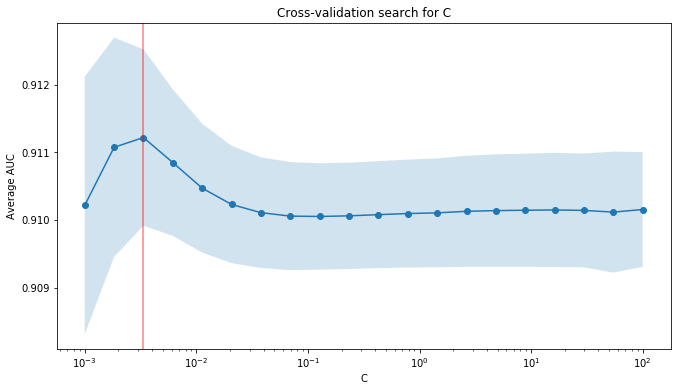

In [266]:
plt.figure(figsize=(11,6))
plt.fill_between(
    list(clf_grid.cv_results_['param_C']),
    [(mean - std) for mean, std in zip(clf_grid.cv_results_["mean_test_score"], clf_grid.cv_results_["std_test_score"])],
    [(mean + std) for mean, std in zip(clf_grid.cv_results_["mean_test_score"], clf_grid.cv_results_["std_test_score"])],
    alpha=0.2
)
plt.plot(
    list(clf_grid.cv_results_['param_C']),
    [x for x in clf_grid.cv_results_["mean_test_score"]],
    '-o'
)
plt.axvline(clf_grid.best_params_["C"], color='r', alpha=0.5)
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Average AUC")
plt.title("Cross-validation search for C")
plt.show()

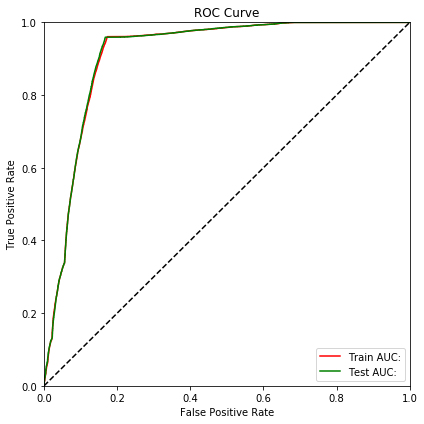

In [296]:
clf = clf_grid.best_estimator_
plt.figure(figsize=(6,6))
fpr_test, tpr_test, thresh = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
roc_auc_test = auc(fpr_test, tpr_test)

fpr, tpr, thresh = roc_curve(y_train, clf.predict_proba(X_train)[:,1])
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'r-',label ='Train AUC:'.format(roc_auc))
plt.plot(fpr_test, tpr_test, 'g-',label ='Test AUC:'.format(roc_auc_test))
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.tight_layout()
plt.legend()
plt.show()


Ques 6. 

- predict class with majority (No-show==0) for all cases

In [282]:
print('All data - Naive predictor accuracy: {:2.2f}%'.format(100 - (100*y.sum()/X.shape[0])))
# row: true label ; columns: predictions
tn, fp, fn, tp = confusion_matrix(y, np.zeros(X.shape[0])).ravel()
(tn, fp, fn, tp)

All data - Naive predictor accuracy: 50.00%


(88208, 0, 88208, 0)

It seems that the naive model does not classify correctly any of out positivies entries. The 88208 false negatives (this model have poor recall). Data needed to be scaled to improve the model.



In [305]:
print('AUC on test set',cross_val_score(logreg, X_test,y_test, scoring='roc_auc', cv = 2))

AUC on test set [0.91064535 0.91209281]


Higher AUC is better, therefore the result is good